In [10]:
import numpy  as np
import pandas as pd
import matplotlib.pylab as plt

# All things necessary to run the simulation
from hamopy import ham_library as ham
from hamopy.classes import Mesh, Boundary, Time
from hamopy.algorithm import calcul
from hamopy.postpro import evolution

# Choice of materials and geometry
from hamopy.materials.hamstad import BM3

In [11]:
# # Load the CSV
# data_path = "/Users/liuzikai/Desktop/Pycharm/Climate/VTT Model Demo/Nasa_UK_21-22.csv"
# df = pd.read_csv(data_path)
#
# # Convert Date to datetime format
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
#
# # Create 'Time(d)' and 'Time (s)' columns
# start_date = df['Date'].iloc[0]
# df['Time(d)'] = (df['Date'] - start_date).dt.days
# df['Time (s)'] = df['Time(d)'] * 86400
#
# # Convert 'TS' (Temperature in Celsius) to 'Temp. (K)' (Temperature in Kelvin)
# df['Temp. (K)'] = df['TS'] + 273.15
#
# # Convert 'RH2M' to ratio
# df['HR'] = df['RH2M'] / 100
#
# # Filter the required columns
# output_df = df[['Time(d)', 'Time (s)', 'Temp. (K)', 'HR']]
#
# # Rename the columns based on your desired format
# output_df.columns = ["Time(d)", "Time (s)", "Temperature", "Humidity"]
#
# # Filter to first 100 days
# output_df = output_df[output_df['Time(d)'] < 100]
#
# # Save the transformed data to a TXT file
# output_path = "/Users/liuzikai/Desktop/Pycharm/Climate/VTT Model Demo/BM3_climate_transformed.txt"
# output_df.to_csv(output_path, sep='\t', index=False)


In [12]:
mesh = Mesh(**{"materials"    : [BM3],
               "sizes"        : [0.2],
               "nbr_elements" : [40] })

In [13]:
# Boundary conditions
clim_file = 'BM3_climate_transformed.txt'
clim1 = Boundary('Fourier',**{"file"      : clim_file,
                              "time"      : "Time (s)",
                              "T"         : "Temperature",
                              "HR"        : "Humidity",
                              "h_t"       : 10,
                              "h_m"       : 2e-7,})

clim2 = Boundary('Fourier',**{"T"         : 275.15,
                              "HR"        : 0.8,
                              "h_t"       : 10,
                              "h_m"       : 7.38e-12 })
clim = [clim1, clim2]

In [14]:
# Initial conditions
init = {'T'  : 293.15,
        'HR' : 0.95}

# Time step control
time = Time('variable',**{"delta_t"  : 900,
                          "t_max"    : 8640000,
                          "iter_max" : 12,
                          "delta_min": 1e-3,
                          "delta_max": 900 } )

In [15]:
# Calculation
results = calcul(mesh, clim, init, time)

In [16]:
# Post processing: what time and coordinate scales we wish to display the results on
data0 = pd.read_csv(clim_file, delimiter='\t')
t_out = np.array( data0['Time (s)'] )
x_out = [0.05, 0.1, 0.15, 0.17, 0.19]

In [17]:
# Use the evolution function to extract the temperature and humidity profiles
Temperature = np.column_stack([evolution(results, 'T', _, t_out) for _ in x_out])
Humidity = np.column_stack([evolution(results, 'HR', _, t_out) for _ in x_out])
MoistureContent = BM3.w(ham.p_c(Humidity, Temperature), Temperature)

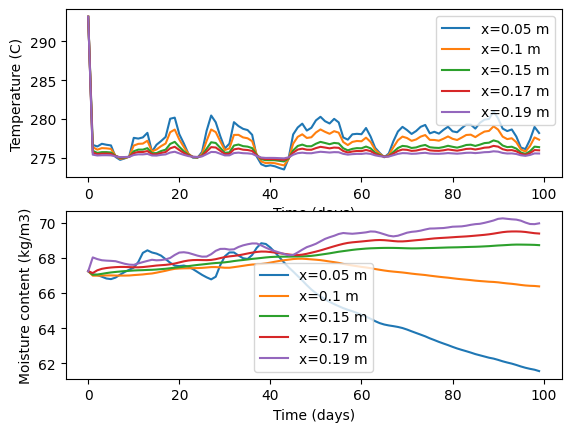

In [18]:
# Plotting results
fig, ax = plt.subplots(2, 1)
ax[0].plot(t_out / (24 * 3600), Temperature)
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Temperature (C)')
ax[0].legend(('x=0.05 m', 'x=0.1 m', 'x=0.15 m', 'x=0.17 m', 'x=0.19 m'))
ax[1].plot(t_out / (24 * 3600), MoistureContent)
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Moisture content (kg/m3)')
ax[1].legend(('x=0.05 m', 'x=0.1 m', 'x=0.15 m', 'x=0.17 m', 'x=0.19 m'))
plt.show()